In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [319]:
import matplotlib.dates as mdates  # 关键：导入 mdates 模块
from matplotlib.ticker import FuncFormatter

def plot_cumulative_returns(df, title="不同Platform长度的累计收益曲线", 
                           figsize=(12, 8), grid=True, 
                           color_list=None, linewidth=2):
    """
    绘制不同platform长度的累计收益曲线图
    
    参数:
    df: DataFrame，index为日期，columns为不同platform长度，值为每日收益率
    title: 图表标题
    figsize: 图表大小，元组(宽, 高)
    grid: 是否显示网格线
    color_list: 自定义颜色列表，若为None则使用默认颜色循环
    linewidth: 线条宽度
    """
    # 计算累计收益（假设输入的是每日收益率，且为小数形式，如0.01表示1%）
    # 累计收益公式：(1 + 日收益率)的连乘 - 1
    cumulative_returns = (1 + df).cumprod() - 1
    
    # 设置中文字体，避免中文乱码
    plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
    plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
    
    # 创建画布
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制每条累计收益曲线
    columns = cumulative_returns.columns
    for i, col in enumerate(columns):
        # 选择颜色（自定义或默认）
        color = color_list[i] if color_list and i < len(color_list) else None
        # 绘制曲线
        ax.plot(cumulative_returns.index, cumulative_returns[col], 
                label=col, linewidth=linewidth, color=color)
    
    # 设置标题和坐标轴标签
    ax.set_title(title, fontsize=15)
    ax.set_xlabel("日期", fontsize=12)
    ax.set_ylabel("累计收益率", fontsize=12)
    
    # 格式化x轴日期（自动适应日期密度）
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)  # 日期旋转45度，避免重叠
    
    # 格式化y轴为百分比
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # 添加网格线
    if grid:
        ax.grid(linestyle='--', alpha=0.7)
    
    # 添加图例，位置在右上角
    ax.legend(title="Platform长度", title_fontsize=12, fontsize=10)
    
    # 调整布局，避免标签被截断
    plt.tight_layout()
    
    return fig, ax

In [317]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def plot_cumulative_returns(df, title="不同Platform长度的累计收益曲线（累加）", 
                           figsize=(12, 8), grid=True, 
                           color_list=None, linewidth=2):
    """
    绘制不同platform长度的累计收益曲线图（使用累加算法，不考虑复利）
    
    参数:
    df: DataFrame，index为日期，columns为不同platform长度，值为每日收益率（小数形式，如0.01表示1%）
    title: 图表标题
    figsize: 图表大小，元组(宽, 高)
    grid: 是否显示网格线
    color_list: 自定义颜色列表，若为None则使用默认颜色循环
    linewidth: 线条宽度
    """
    # 计算累计收益（累加算法：直接汇总每日收益率，不考虑复利）
    cumulative_returns = df.cumsum()  # 核心修改：用cumsum()替代cumprod()
    
    # 设置中文字体，避免中文乱码
    plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
    plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
    
    # 创建画布
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制每条累计收益曲线
    columns = cumulative_returns.columns
    for i, col in enumerate(columns):
        # 选择颜色（自定义或默认）
        color = color_list[i] if color_list and i < len(color_list) else None
        # 绘制曲线
        ax.plot(cumulative_returns.index, cumulative_returns[col], 
                label=col, linewidth=linewidth, color=color)
    
    # 设置标题和坐标轴标签
    ax.set_title(title, fontsize=15)
    ax.set_xlabel("日期", fontsize=12)
    ax.set_ylabel("累计收益率（累加）", fontsize=12)  # 标题注明“累加”以区分
    
    # 格式化x轴日期（自动适应日期密度）
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)  # 日期旋转45度，避免重叠
    
    # 格式化y轴为百分比
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # 添加网格线
    if grid:
        ax.grid(linestyle='--', alpha=0.7)
    
    # 添加图例，位置在右上角
    ax.legend(title="Platform长度", title_fontsize=12, fontsize=10)
    
    # 调整布局，避免标签被截断
    plt.tight_layout()
    
    return fig, ax

In [120]:
def process_indicator(data, indicator_name):
    # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
    long_df = data.stack(dropna = True).reset_index()
    # 重命名列：股票ID、时间、指标值
    long_df.columns = ['stock_id', 'time', 'value']
    # 添加指标类型列（如'post'、'high'）
    long_df['indicator'] = indicator_name
    return long_df

In [175]:
###预处理 拼成长表
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
next_uplimit_data = (ff.read('up_limit') * post_data * ff.filter0).shift(-1,axis = 1)
next_open_data = (ff.read('open') * post_data * ff.filter0).shift(-1,axis = 1)


df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_next_uplimit = process_indicator(next_uplimit_data, 'next_uplimit')
df_next_open = process_indicator(next_open_data, 'next_open')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_next_uplimit,df_next_open],
    ignore_index=True
)

In [197]:
stock_list = long_table['stock_id'].unique().tolist()

In [135]:
def init_worker(table):
    global shared_table
    shared_table = table

init_worker(long_table)

In [4]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak
    # 创建peak列，默认值为NaN
    '''
    
    df['peak'] = np.nan
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak'] = 'high'
            continue  # 找到高点后继续下一个点
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak'] = 'low'
    
    return df

In [5]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform'] = np.nan
    df['platform_length'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peak_col = df.columns.get_loc('peak')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            peak_val = df.iloc[j, peak_col]
            
            if peak_val == 'high':
                current_high_low = df.iloc[j, low_col]
            elif peak_val == 'low':
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                df.iloc[i, df.columns.get_loc('platform')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                break  # 找到平台后跳出内层循环
    
    return df

In [235]:
def run(df, start_date, end_date, stock_id):
    """
    回测函数（按platform_length分类计算）
    输入：DataFrame 对应一支股票，index是日期，columns包含 high, low, open, close, platform, uplimit, platform_length
    输出：DataFrame 长表格式，columns=['stock_id', 'time', 'platform_length']
    """
    # 1. 筛选基础符合条件的交易日（包含platform_length）
    df['valid'] = (df['high'] > df['platform']) & (df['next_uplimit'] != df['next_open']) &  (df.index >= start_date) & (df.index <= end_date) & (df['platform_length'].notna())
    df['valid'] = df['valid'].shift(1).fillna(False)
    df['platform_length'] = df['platform_length'].shift(1)
    valid_days = df[df['valid']]  # 确保platform_length非空
    
    # 2. 初始化结果列表
    result_data = []
    
    # 3. 遍历每个有效交易日
    for idx in valid_days.index:
        # 获取平台长度并转换为分类
        platform_length = valid_days.loc[idx, 'platform_length']
        if pd.isna(platform_length):
            continue
            
        # 确定分类
        if platform_length == 2:
            category = '2'
        elif platform_length == 3:
            category = '3'
        elif platform_length == 4:
            category = '4'
        elif platform_length == 5:
            category = '5'
        elif platform_length == 6:
            category = '6'
        else:  # >=7
            category = '≥7'
        
        num_index = df.index.get_loc(idx)
        try:
            daily_ret = (df.iloc[num_index + 1]['close'] - df.iloc[num_index]['open']) / (2 * df.iloc[num_index]['open'])
        except:
            daily_ret = None
        # 添加到结果列表
        result_data.append({
            'stock_id': stock_id,
            'time': idx,
            'platform_length': category,
            'daily_return':daily_ret
        })
    
    # 4. 转换为DataFrame并返回
    return pd.DataFrame(result_data)

In [194]:
def stock_process(stock_id,start_date = '2020-01-03',end_date = '2025-07-10'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：stock_id对应的所有信号df
    df = shared_table[shared_table['stock_id'] == stock_id]
    if not df.empty:
        stock_data = df.pivot(index='time',
                            columns='indicator',
                            values='value')
        stock_data.index = pd.to_datetime(stock_data.index)
        stock_data = climax_find(stock_data)
        stock_data = platform_find(stock_data)
        res_df = run(stock_data,start_date,end_date,stock_id)
        return res_df
    else:
        return pd.DataFrame

In [239]:
'''
Task5:记突破平台的时间是0，记录1-2天内的日平均收益 根据平台长度分类绘制日收益曲线
'''

with Pool(100, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total=len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df = pd.concat(res_lst, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5108/5108 [06:47<00:00, 12.55it/s]


In [241]:
grouped_df = final_df.groupby(['time', 'platform_length'])['daily_return'].mean().reset_index()

In [242]:
wide_df = grouped_df.pivot(
    index='time',           # 行索引：日期
    columns='platform_length',  # 列索引：平台长度
    values='daily_return'   # 值：平均日收益率
).fillna(0)

In [315]:
wwdf = wide_df.loc['2020':]

(<Figure size 1200x800 with 1 Axes>,
 <AxesSubplot:title={'center':'不同Platform长度的累计收益曲线'}, xlabel='日期', ylabel='累计收益率'>)

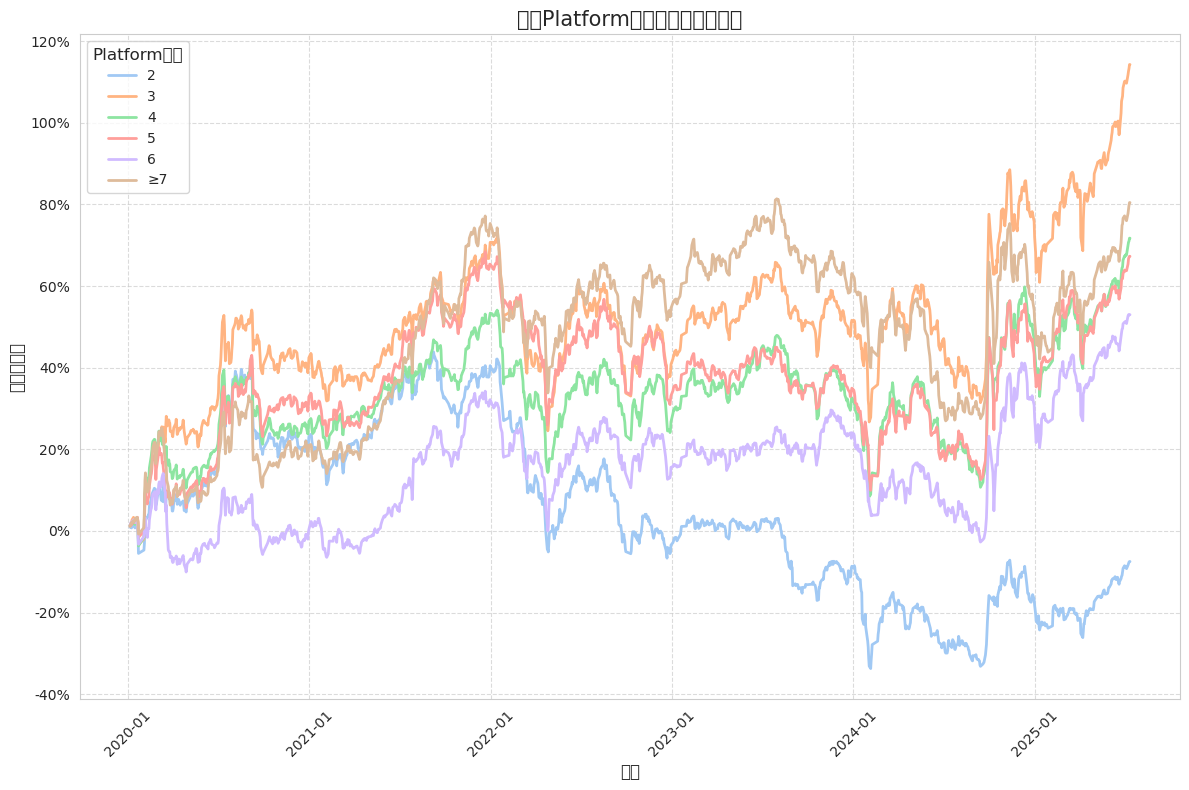

In [320]:
plot_cumulative_returns(wwdf)